In [1]:
import torch
import numpy as np 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat

In [2]:
def masks_to_layout(vecs, boxes, masks, obj_to_img, H, W=None, pooling='sum', test_mode=False):
    """
    Inputs:
    - vecs: Tensor of shape (O, D) giving vectors, D = label_emb_dim + layout_noise_dim = 192
    - boxes: Tensor of shape (O, 4) giving bounding boxes in the format
      [x0, y0, x1, y1] in the [0, 1] coordinate space
    - masks: Tensor of shape (O, M, M) giving binary masks for each object
    - obj_to_img: LongTensor of shape (O,) mapping objects to images
    - H, W: Size of the output image.

    Returns:
    - out: Tensor of shape (N, D, H, W)
    """
    O, D = vecs.size()
    M = masks.size(1)
    assert masks.size() == (O, M, M)
    if W is None:
        W = H

    grid = _boxes_to_grid(boxes, H, W)

    img_in = vecs.view(O, D, 1, 1) * masks.float().view(O, 1, M, M) # broadcast. O, D, M, M
    sampled = F.grid_sample(img_in, grid)
    if test_mode:
        clean_mask_sampled = F.grid_sample(masks.float().view(O, 1, M, M), grid)
    else:
        clean_mask_sampled = None

    out = _pool_samples(sampled, clean_mask_sampled, obj_to_img, pooling=pooling)
    return out


def _boxes_to_grid(boxes, H, W):
    """
    Input:
    - boxes: FloatTensor of shape (O, 4) giving boxes in the [x0, y0, x1, y1]
      format in the [0, 1] coordinate space
    - H, W: Scalars giving size of output

    Returns:
    - grid: FloatTensor of shape (O, H, W, 2) suitable for passing to grid_sample
    """
    O = boxes.size(0)

    boxes = boxes.view(O, 4, 1, 1)

    # All these are (O, 1, 1)
    x0, y0 = boxes[:, 0], boxes[:, 1]
    ww, hh = boxes[:, 2] - x0, boxes[:, 3] - y0

    X = torch.linspace(0, 1, steps=W).view(1, 1, W).to(boxes)
    Y = torch.linspace(0, 1, steps=H).view(1, H, 1).to(boxes)

    X = (X - x0) / ww  # (O, 1, W)
    Y = (Y - y0) / hh  # (O, H, 1)

    # Stack does not broadcast its arguments so we need to expand explicitly
    X = X.expand(O, H, W)
    Y = Y.expand(O, H, W)
    grid = torch.stack([X, Y], dim=3)  # (O, H, W, 2)

    # Right now grid is in [0, 1] space; transform to [-1, 1]
    grid = grid.mul(2).sub(1)

    return grid


def _pool_samples(samples, clean_mask_sampled, obj_to_img, pooling='sum'):
    """
    Input:
    - samples: FloatTensor of shape (O, D, H, W)
    - obj_to_img: LongTensor of shape (O,) with each element in the range
      [0, N) mapping elements of samples to output images

    Output:
    - pooled: FloatTensor of shape (N, D, H, W)
    """
    dtype, device = samples.dtype, samples.device
    O, D, H, W = samples.size()
    N = obj_to_img.data.max().item() + 1

    # Use scatter_add to sum the sampled outputs for each image
    # out = torch.zeros(N, D, H, W, dtype=dtype, device=device)
    # idx = obj_to_img.view(O, 1, 1, 1).expand(O, D, H, W)
    # out = out.scatter_add(0, idx, samples)
    obj_to_img_list = [i.item() for i in list(obj_to_img)]
    all_out = []
    if clean_mask_sampled is None:
        for i in range(N):
            start = obj_to_img_list.index(i)
            end = len(obj_to_img_list) - obj_to_img_list[::-1].index(i)
            all_out.append(torch.sum(samples[start:end, :, :, :], dim=0))
    else:
        _, d, h, w = samples.shape
        for i in range(N):
            start = obj_to_img_list.index(i)
            end = len(obj_to_img_list) - obj_to_img_list[::-1].index(i)
            mass = [torch.sum(samples[j, :, :, :]).item() for j in range(start, end)]
            argsort = np.argsort(mass)
            result = torch.zeros((d, h, w), device=samples.device, dtype=samples.dtype)
            result_clean = torch.zeros((h, w), device=samples.device, dtype=samples.dtype)
            for j in argsort:
                masked_mask = (result_clean == 0).float() * (clean_mask_sampled[start + j, 0] > 0.5).float()
                result_clean += masked_mask
                result += samples[start + j] * masked_mask
            all_out.append(result)
    out = torch.stack(all_out)

    if pooling == 'avg':
        # Divide each output mask by the number of objects; use scatter_add again
        # to count the number of objects per image.
        ones = torch.ones(O, dtype=dtype, device=device)
        obj_counts = torch.zeros(N, dtype=dtype, device=device)
        obj_counts = obj_counts.scatter_add(0, obj_to_img, ones)
        # print(obj_counts)
        obj_counts = obj_counts.clamp(min=1)
        out = out / obj_counts.view(N, 1, 1, 1)
    elif pooling != 'sum':
        raise ValueError('Invalid pooling "%s"' % pooling)

    return out



In [3]:

if __name__ == '__main__':
    vecs = torch.FloatTensor([
        [1, 0, 0], [0, 1, 0], [0, 0, 1],
        [1, 0, 0], [0, 0, 1], [0, 1, 1],
    ]) ## indicate color
    boxes = torch.FloatTensor([ # top-left, bottom-right
        [0.25, 0.125, 0.5, 0.875], 
        [0, 0, 1, 0.25],
        [0.6125, 0, 0.875, 1],
        [0, 0.8, 1, 1.0],
        [0.25, 0.125, 0.5, 0.875],
        [0.6125, 0, 0.875, 1],
    ])
    obj_to_img = torch.LongTensor([0, 0, 0, 1, 1, 1])
    # vecs = torch.FloatTensor([[[1]]])
    # boxes = torch.FloatTensor([[[0.25, 0.25, 0.75, 0.75]]])
    vecs, boxes = vecs.cuda(), boxes.cuda()
    obj_to_img = obj_to_img.cuda()
    # out = boxes_to_layout(vecs, boxes, obj_to_img, 256, pooling='sum')

    from torchvision.utils import save_image

    # save_image(out.data, 'out.png')

    masks = torch.FloatTensor([
        [
            [0, 0, 1, 0, 0],
            [0, 1, 1, 1, 0],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 0, 1, 0, 0],
            [0, 1, 0, 1, 0],
            [1, 0, 0, 0, 1],
            [0, 1, 0, 1, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 1, 1, 1, 0],
            [0, 1, 1, 1, 0],
            [0, 1, 1, 1, 0],
            [0, 1, 1, 1, 0],
            [0, 1, 1, 1, 0],
        ],
        [
            [0, 0, 1, 0, 0],
            [0, 1, 1, 1, 0],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 1, 0, 0],
            [0, 1, 1, 1, 0],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 0],
            [0, 0, 1, 0, 0],
        ]
    ])
    masks = masks.cuda()
    out = masks_to_layout(vecs, boxes, masks, obj_to_img, 256)
    out = out.cpu()
    # save_image(out.data, 'out_masks.png')


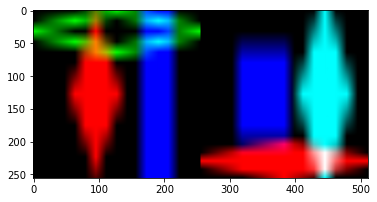

In [4]:
im2 = rearrange(out, 'n c h w -> h (n w) c')
plt.imshow(im2)

## cv2.rectangle(img, (x0,y0), (x1,y1), color, thickness)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


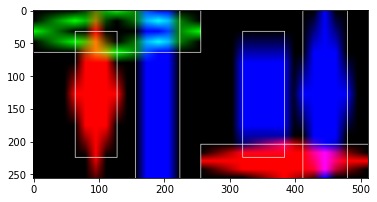

In [88]:
# draw bbox using cv2
import cv2
img = im2.numpy().copy()
bbox = boxes.cpu().numpy()
bbox = bbox*256
for bb in bbox[:3]:
    cv2.rectangle(img, (bb[0], bb[1]), (bb[2], bb[3]), (255,255,255), 1)


for bb in bbox[3:]:
    cv2.rectangle(img, (int(bb[0]+256), bb[1]), (int(256+bb[2]), bb[3]), (255,255,255), 1)
plt.imshow(img)

In [60]:
# Draw bbox using ImageDraw
# from PIL import ImageDraw,Image
# img = Image.fromarray(im2.numpy())
# draw = ImageDraw.Draw(img)
# bbox = boxes.numpy().tolist()
# for bb in bbox[:3]:
#     draw.rectangle(bb)
# imshow(img)


TypeError: Cannot handle this data type: (1, 1, 3), <f4